In [1]:
# encoding=utf8

# Correlation Analysis


+ Samples for the section "Correlation Analysis" Data Exploration

Note: 
    missingno, Missing data visualization module for Python

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Task 1

In [3]:
train=pd.read_csv('../../DataSets/pybk010master/train.csv')
test=pd.read_csv('../../DataSets/pybk010master/test.csv')

In [4]:
contfeatureslist=[]
for colname,x in train.iloc[1,:].iteritems():
    if( not str(x).isalpha()):
        contfeatureslist.append(colname)

In [5]:
contfeatureslist

['id',
 'cont1',
 'cont2',
 'cont3',
 'cont4',
 'cont5',
 'cont6',
 'cont7',
 'cont8',
 'cont9',
 'cont10',
 'cont11',
 'cont12',
 'cont13',
 'cont14',
 'loss']

In [6]:
contfeatureslist.remove("id")
contfeatureslist.remove("loss")

/Users/bater.makhabel/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


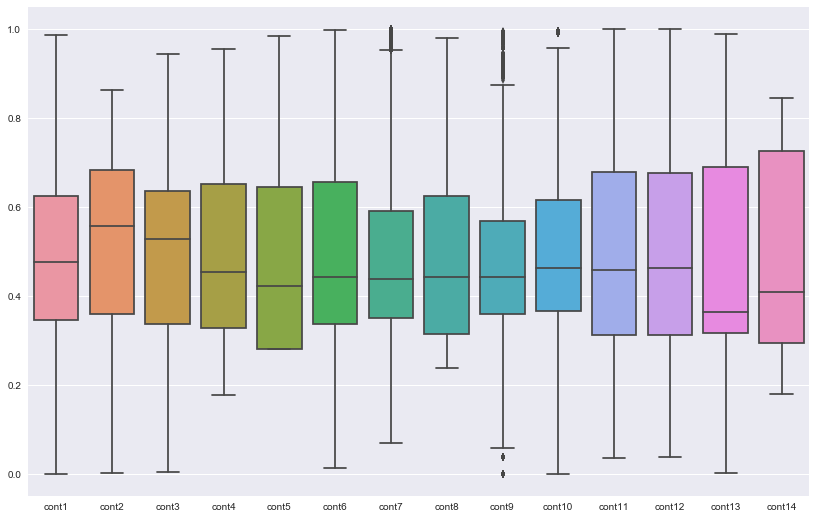

In [7]:
import seaborn as sns
plt.figure(figsize=(14,9))
sns.boxplot(train[contfeatureslist])

In [8]:
#include target variables to find correlation between features and target features as well
contfeatureslist.append("loss")

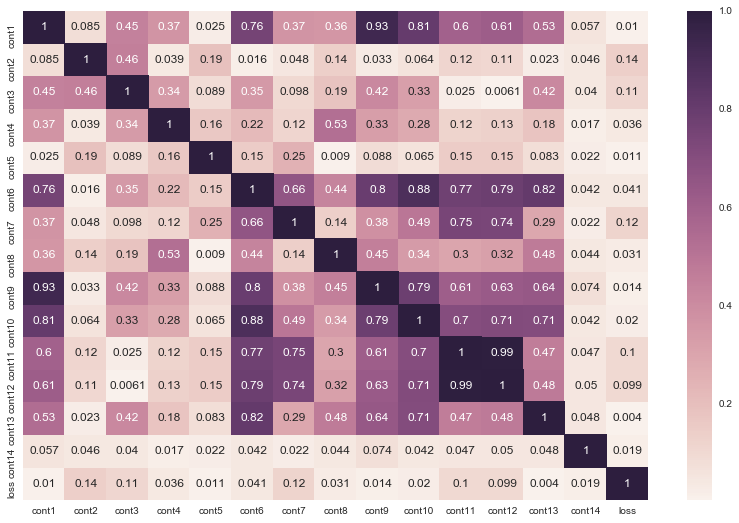

In [9]:
correlationmatrix=train[contfeatureslist].corr().abs()
plt.subplots(figsize=(14,9))
sns.heatmap(correlationmatrix, annot=True)
#
sns.heatmap(correlationmatrix, mask= correlationmatrix<1,cbar=False)
plt.show()

# Task 2

In [ ]:
!pip install nitime
!pip install xray
!pip install rpy2

In [ ]:
%matplotlib inline
from scipy import interpolate
from scipy import special
from scipy.signal import butter, lfilter, filtfilt
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
from nitime import algorithms as alg
from nitime import utils
from scipy.stats import t
import xray
import pandas as pd
from rpy2.robjects import FloatVector
from rpy2.robjects.vectors import StrVector
import rpy2.robjects as robjects    
from rpy2.robjects.packages import importr
r = robjects.r

Define functions for filtering, moving averages, and normalizing data

In [ ]:
def butter_lowpass(cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def filter(x, cutoff, axis, fs=1.0, order=3):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, x, axis=axis)
    return y

def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'valid')

def owncorr(x,y,n):
    x_ano=np.ma.anomalies(x)
    x_sd=np.sum(x_ano**2,axis=0)
    y_ano=np.ma.anomalies(y)
    y_sd=np.sum(y_ano**2,axis=0)
    nomi = np.dot(x_ano,y_ano)
    corr = nomi/np.sqrt(np.dot(x_sd[None],y_sd[None]))

    x_coef, x_sigma = alg.AR_est_YW (x, 1)
    y_coef, y_sigma = alg.AR_est_YW (y, 1)
    neff = n*(1-x_coef*y_coef)/(1+x_coef*y_coef)

    if neff <3:
        neff = 3
    
    coef = []
    coef.append(x_coef)
    coef.append(y_coef)
    tval = corr/np.sqrt(1-corr**2)*np.sqrt(neff-2)
    pval = t.sf(abs(tval),neff-2)*2
    
    return corr,pval,coef

def gaussianize(X):
    n = X.shape[0]
    #p = X.shape[1]

    Xn = np.empty((n,))
    Xn[:] = np.NAN
    nz = np.logical_not(np.isnan(X))

    index = np.argsort(X[nz])
    rank = np.argsort(index)

    CDF = 1.*(rank+1)/(1.*n) -1./(2*n)
    Xn[nz] = np.sqrt(2)*special.erfinv(2*CDF -1)
    return Xn

Read bandwidth and rain/temperature data and normalize them

In [ ]:
data = genfromtxt('../../DataSets/pybk011master/scotland.csv', delimiter=',')
bandw = data[0:115,4] # band width (1879-1993), will be correlated with T/P
bandwl = data[3:129,4] # band width (1865-1990), will be correlation with winter NAO
bandwn = gaussianize(bandw) #normalized band width
bandwln = gaussianize(bandwl) #normalized band width

rain = genfromtxt('../../DataSets/pybk011master/Assynt_P.txt') #precipitaiton
temp = genfromtxt('../../DataSets/pybk011master/Assynt_T.txt') #temperature
#wnao = genfromtxt('../../DataSets/pybk011master/wnao.txt') #winter NAO
#wnao = wnao[::-1]

rainn = gaussianize(rain)
tempn = gaussianize(temp)

#calculate the ratio of temperature over precipitation
ratio = temp/rain
ration = gaussianize(ratio)

Smoothing data (11-year running average)

In [ ]:
bandw_fil = movingaverage(bandw, 11)
bandwn_fil = movingaverage(bandwn, 11)
bandwl_fil = movingaverage(bandwl, 11)
rain_fil = movingaverage(rain, 11)
rainn_fil = movingaverage(rainn, 11)
ratio_fil = movingaverage(ratio, 11)
#wnao_fil = movingaverage(wnao, 11)

Calculate correlation and p-values with considering autocorrelation, and the autocorrelations (coef)

In [ ]:
corr_ratio,pval_ratio,coef = owncorr(bandw_fil,ratio_fil,115) #correlation between smoothed bandwidth and ratio
#corr_nao,pval_nao,coef_nao = owncorr(bandwl_fil,wnao_fil,126) #correlation between smoothed bandwidth and winter NAO
corr_n,pval_n,coef_n = owncorr(bandwn,ration,115) #correlation between normalized bandwidth and ratio
#corr_naon,pval_naon,coef_naon = owncorr(bandwln,wnao,126) #correlation between normalized bandwidtha and winter NAO

Check the correlation results

In [ ]:
print(corr_ratio)
print(pval_ratio)
print(coef)
#print(corr_nao)
#print(pval_nao)
#print(coef_nao)

print(corr_n)
print(pval_n)
print(coef_n)
#print(corr_naon)
#print(pval_naon)
#print(coef_naon)

# Task 3: 图表相关分析（折线图及散点图）

# Task 4: 协方差及协方差矩阵

# Task 5: 相关系数

# Task 6: 一元回归及多元回归

# Task 7: 信息熵及互信息